# 10wk-38: 아이스크림 – 의사결정나무 원리

최규빈  
2023-11-10

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-ypGHw375XVlBInqUzsxdd8&si=BWDa9FfxtVfYd6dj>

# 2. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython
import sklearn.tree
#---#
import warnings
warnings.filterwarnings('ignore')

# 3. Data

In [2]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:100]
temp.sort()
eps = np.random.randn(100)*3 # 오차
icecream_sales = 20 + temp * 2.5 + eps 
df_train = pd.DataFrame({'temp':temp,'sales':icecream_sales})
df_train

# 4. 의사결정나무 원리

## A. 분할이 정해졌을때 $\hat{y}$을 결정하는 방법?

`-` step1~4

In [3]:
## step1
X = df_train[['temp']]
y = df_train['sales']
## step2
predictr = sklearn.tree.DecisionTreeRegressor(max_depth=1) 
## step3 
predictr.fit(X,y) 
## step4 -- pass 
# predictr.predict(X) 

`-` tree 시각화 $\to$ 분할파악

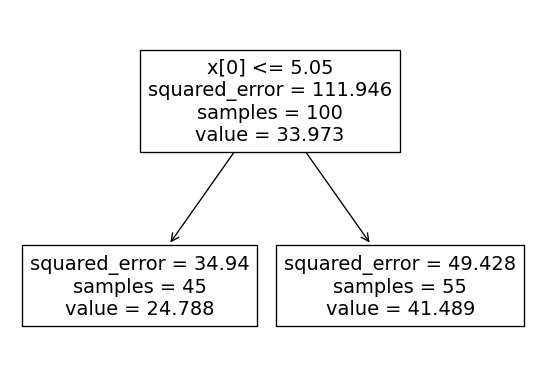

In [4]:
sklearn.tree.plot_tree(predictr)

`-` 분할에 따른 $\hat{y}$ 계산

In [5]:
df_train[df_train.temp<= 5.05].sales.mean(),df_train[df_train.temp> 5.05].sales.mean()

## B. 분할을 결정하는 방법?

`-` 예비학습

In [6]:
predictr.score(X,y)

-   이 값이 내부적으로 어떻게 계산된거지?

In [7]:
predictr.score??

In [8]:
y_hat = y_pred = predictr.predict(X)
sklearn.metrics.r2_score(y,y_pred)

`-` 좋은 분할을 판단하는 기준? – 여기에서 `r2_score`가 이용됨

`-` 우선 논의를 편하게하기 위해서 $({\bf X},{\bf y})$와 경계값 $c$를
줄때 $\hat{\bf y}$을 계산해주는 함수를 구현하자.

In [9]:
def fit_predict(X,y,c):
    X = np.array(X).reshape(-1)
    y = np.array(y) 
    yhat = y*0   
    yhat[X<=c] = y[X<=c].mean()
    yhat[X>c] = y[X>c].mean()
    return yhat

`-` 서로 다른 분할에 대하여 시각화를 진행

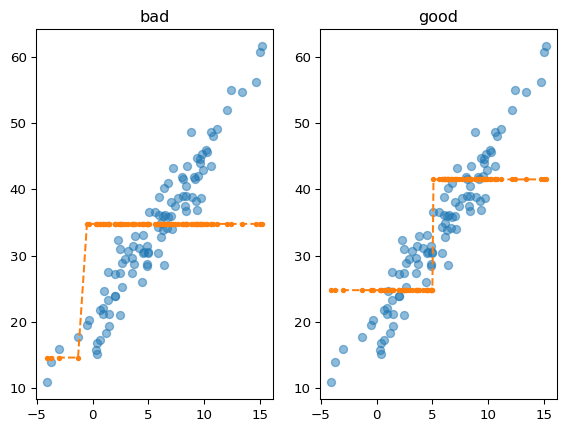

In [10]:
yhat_bad = fit_predict(X,y,c=-1)
yhat_good = fit_predict(X,y,c=5)
fig, ax = plt.subplots(1,2) 
ax[0].plot(X,y,'o',alpha=0.5)
ax[0].plot(X,yhat_bad,'--.')
ax[0].set_title('bad')
ax[1].plot(X,y,'o',alpha=0.5)
ax[1].plot(X,yhat_good,'--.')
ax[1].set_title('good')

-   딱봐도 오른쪽이 좋은 분할같은데, 컴퓨터한테 이걸 어떻게 설명하지?

`-` 좋은분할을 구하는 이유는 좋은 `yhat`을 얻기 위함이다. 그렇다면 좋은
`yhat`을 얻게 해주는 분할이 좋은 분할이라 해석할 수 있다. $\to$
아이디어: 그런데 좋은 `yhat`은 `sklearn.metrics.r2_score(y,yhat)`의 값이
높지 않을까?

`-` 그렇다면 위의 그림에서 왼쪽보다 오른쪽이더 좋은 분할이라면
`r2_score(y,yhat_good)`의 값이 `r2_score(y,yhat_bad)` 값보다 높을 것!

In [11]:
sklearn.metrics.r2_score(y,yhat_bad), sklearn.metrics.r2_score(y,yhat_good)

`-` 트리의 `max_depth=1` 일 경우 분할을 결정하는 방법 – 노가다..

1.  적당한 $c$를 고른다.
2.  분할 $(-\infty,c), [c,\infty)$ 를 생성하고 `yhat`를 계산한다.
3.  `r2_score(y,yhat)`를 계산하고 기록한다.
4.  1-3의 과정을 무한반복 한다. 그리고 `r2_score(y,yhat)`의 값을 가장
    작게 만드는 $c$가 무엇인지 찾는다.

In [12]:
cuts = np.arange(-5,15)
fig = plt.figure()
def func(frame):
    ax = fig.gca()
    ax.clear()
    ax.plot(X,y,'o',alpha=0.5)
    c = cuts[frame] 
    yhat = fit_predict(X,y,c)
    ax.plot(X,yhat,'.')
    r2 = sklearn.metrics.r2_score(y,yhat)
    ax.set_title(f'c={c}, r2_score={r2:.2f}')

In [13]:
ani = matplotlib.animation.FuncAnimation(
    fig,
    func,
    frames=20
)
display(IPython.display.HTML(ani.to_jshtml()))

`-` tree가 찾은 값 5.05를 우리가 직접 찾아보자.

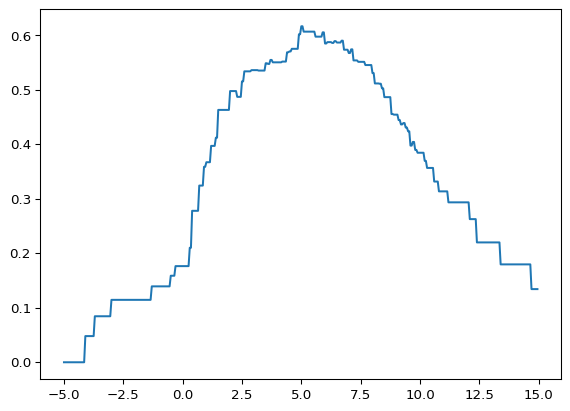

In [14]:
cuts = np.arange(-5,15,0.05).round(2)
score = np.array([sklearn.metrics.r2_score(y,fit_predict(X,y,c)) for c in cuts])
plt.plot(cuts,score)

`-` 방법1: 시각화로 찾는방법

In [15]:
pd.DataFrame({'cut':cuts,'score':score})\
.plot.line(x='cut',y='score',backend='plotly')

`-` 방법2: 정석

In [16]:
cuts[score.argmax()]

`-` `max_depth=2`일 경우? `max_depth=1`의 결과로 발생한 2개의 조각을
각각 전체자료로 생각하고, `max_depth=1`일 때의 분할방법을 반복적용한다.

`-` `X=[temp,type]` 와 같은 경우라면? 설명변수를 하나씩 고정하여 각각
최적분할을 생성하고 r2_score관점에서 가장 우수한 설명변수를 선택